In [ ]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm

In [ ]:
!unzip  drive/MyDrive/data/GAN/06.04.zip -d ./6.4/  > /dev/null

In [ ]:
!unzip drive/MyDrive/data/GAN/11.03.zip -d ./11.3/ > /dev/null

In [ ]:
!unzip drive/MyDrive/data/GAN/23.03.zip -d ./23.3/ > /dev/null

In [ ]:
codings_size = 100
batch_size = 32
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
image_train_gen = keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.2,
                                                         height_shift_range=0.2,
                                                         rescale=1 / 255.,
                                                         horizontal_flip=True,
                                                         fill_mode="nearest",
                                                         validation_split=0.2
                                                         )

image_test_gen = keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.2,
                                                         height_shift_range=0.2,
                                                         rescale=1 / 255.,
                                                         horizontal_flip=True,
                                                         fill_mode="nearest"
                                                         )

## not necessarry here because we need just one class (normal)
train_images = image_train_gen.flow_from_directory(
    directory="./",
    color_mode="rgb",
    class_mode="input",
    subset='training',
    classes=['OK'],
    seed=42
    )
valid_images = image_train_gen.flow_from_directory(
    directory="./",
    color_mode="rgb",
    class_mode="input",
    subset='validation',
    classes=['OK'],
    seed=42
    )
test_images = image_test_gen.flow_from_directory(
    directory="./",
    color_mode="rgb",
    class_mode="input",
    classes=['DEF'],
    seed=42
    )

Found 31041 images belonging to 1 classes.
Found 7760 images belonging to 1 classes.
Found 393 images belonging to 1 classes.


In [ ]:
encoder = keras.models.Sequential([
   keras.layers.Conv2D(16, kernel_size=3, padding="same", activation="selu", input_shape=[256, 256, 3]),
   keras.layers.MaxPool2D(pool_size=2),
   keras.layers.BatchNormalization(),
   keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="selu"),
   keras.layers.MaxPool2D(pool_size=2),
   keras.layers.BatchNormalization(),
   keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="selu"),
   keras.layers.MaxPool2D(pool_size=2),
   keras.layers.BatchNormalization(),
   keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="selu"),
   keras.layers.MaxPool2D(pool_size=2),
   keras.layers.BatchNormalization(),
   keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="selu"),
   keras.layers.MaxPool2D(pool_size=2)
   ])

decoder = keras.models.Sequential([
  keras.layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding="same", activation="selu", input_shape=[8, 8, 256]),
  keras.layers.AlphaDropout(0.2),
  keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="same", activation="selu"),
  keras.layers.AlphaDropout(0.2),
  keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="same", activation="selu"),
  keras.layers.AlphaDropout(0.2),
  keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="same", activation="selu"),
  keras.layers.Conv2DTranspose(3, kernel_size=3, strides=2, padding="same", activation="sigmoid")
])

autoencoder = keras.models.Sequential([encoder, decoder])


In [ ]:
encoder.summary()
decoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 16)     64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                        

In [ ]:
autoencoder.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint("drive/MyDrive/models/AE/6.4/autoencoder-{epoch:02d}-{val_accuracy:.2f}.hdf5",  monitor='val_accuracy', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

autoencoder.fit(train_images, epochs=500, shuffle=True, validation_data=(valid_images), callbacks=[early_stopping_cb, checkpoint_cb])

Epoch 1/500
971/971 [==============================] - 549s 562ms/step - loss: 0.0085 - accuracy: 0.9241 - val_loss: 0.0086 - val_accuracy: 0.9407
Epoch 2/500
971/971 [==============================] - 537s 553ms/step - loss: 0.0028 - accuracy: 0.9560 - val_loss: 0.0063 - val_accuracy: 0.9442
Epoch 3/500
971/971 [==============================] - 540s 557ms/step - loss: 0.0023 - accuracy: 0.9574 - val_loss: 0.0055 - val_accuracy: 0.9504
Epoch 4/500
971/971 [==============================] - 541s 557ms/step - loss: 0.0021 - accuracy: 0.9576 - val_loss: 0.0053 - val_accuracy: 0.9415
Epoch 5/500
971/971 [==============================] - 535s 551ms/step - loss: 0.0019 - accuracy: 0.9587 - val_loss: 0.0050 - val_accuracy: 0.9490
Epoch 6/500
971/971 [==============================] - 532s 548ms/step - loss: 0.0018 - accuracy: 0.9590 - val_loss: 0.0046 - val_accuracy: 0.9418
Epoch 7/500
971/971 [==============================] - 535s 551ms/step - loss: 0.0017 - accuracy: 0.9597 - val_loss: 0

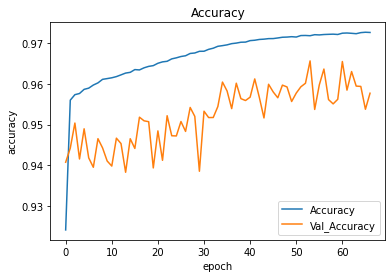

In [ ]:
history = autoencoder.history.history
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Accuracy', 'Val_Accuracy'], loc='lower right')
plt.show()

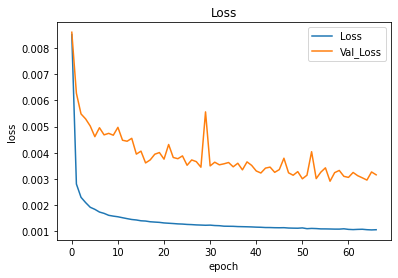

In [ ]:
history = autoencoder.history.history
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Loss', 'Val_Loss'], loc='upper right')
plt.show()

In [ ]:
model = keras.models.load_model("drive/MyDrive/models/AE/6.4/autoencoder-54-0.97.hdf5")

In [ ]:
metrics = []
path = glob.glob("./6.4/OK/*.jpg")
for i, file in enumerate(tqdm(path)):
    img = plt.imread(file)
    img = cv2.resize(img,(256,256))
    img  = img / 255.
    img = np.asarray([img])
    metrics.append(model.evaluate(img, img, verbose=0))

100%|██████████| 354/354 [00:18<00:00, 19.37it/s]


In [ ]:
metrics = np.asarray(metrics)
np.shape(metrics)
print(metrics[1])
TN = len(metrics[metrics[:, 0] < 0.0037])
print(TN)
print (TN / len(metrics) * 100 )

[0.00340341 0.95983887]
316
89.26553672316385


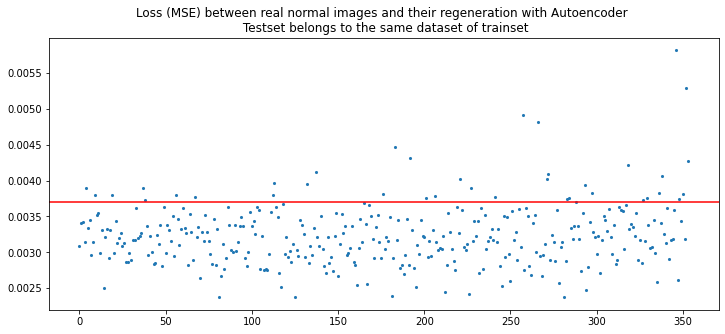

In [ ]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 1, 1)

x = range(len(metrics))
y = metrics[:,0]
ax.set_title("Loss (MSE) between real normal images and their regeneration with Autoencoder \n Testset belongs to the same dataset of trainset")
ax.scatter(x, y, marker='.',  linewidths=0.1)
ax.axhline(y = 0.0037, color = 'r', linestyle = '-')
plt.show()

In [ ]:
metrics = []
path = glob.glob("./6.4/DEF/*.jpg")
for i, file in enumerate(tqdm(path)):
    img = plt.imread(file)
    img = cv2.resize(img,(256,256))
    img  = img / 255.
    img = np.asarray([img])
    metrics.append(model.evaluate(img, img, verbose=0))

100%|██████████| 285/285 [00:15<00:00, 18.93it/s]


In [ ]:
metrics = np.asarray(metrics)
np.shape(metrics)
print(metrics[1])
TN = len(metrics[metrics[:, 0] > 0.0037])
print(TN)
print (TN / len(metrics) * 100 )

[0.00642089 0.93049622]
276
96.84210526315789


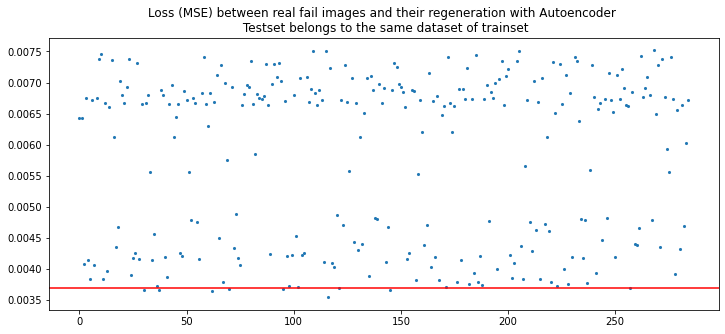

In [ ]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 1, 1)

x = range(len(metrics))
y = metrics[:,0]
ax.set_title("Loss (MSE) between real fail images and their regeneration with Autoencoder \n Testset belongs to the same dataset of trainset")
ax.scatter(x, y, marker='.',  linewidths=0.1)
ax.axhline(y = 0.0037, color = 'r', linestyle = '-')
plt.show()

In [ ]:
metrics = []
path = glob.glob("./11.3/OK/*.jpg")
for i, file in enumerate(tqdm(path)):
    img = plt.imread(file)
    img = cv2.resize(img,(256,256))
    img  = img / 255.
    img = np.asarray([img])
    metrics.append(model.evaluate(img, img, verbose=0))

100%|██████████| 659/659 [00:34<00:00, 19.38it/s]


In [ ]:
metrics = np.asarray(metrics)
np.shape(metrics)
print(metrics[1])
TN = len(metrics[metrics[:, 0] < 0.0037])
print(TN)
print (TN / len(metrics) * 100 )

[0.00287172 0.95651245]
559
84.82549317147192


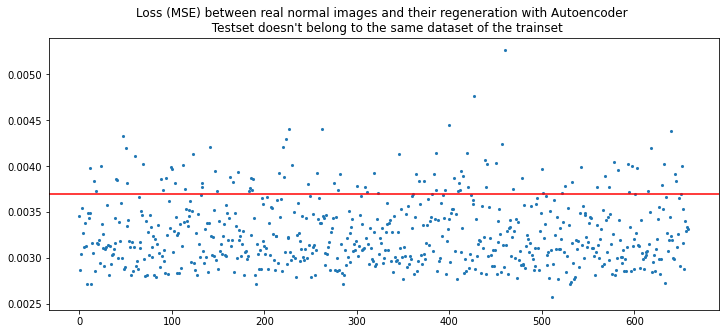

In [ ]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 1, 1)

x = range(len(metrics))
y = metrics[:,0]
ax.set_title("Loss (MSE) between real normal images and their regeneration with Autoencoder \n  Testset doesn't belong to the same dataset of the trainset")
ax.scatter(x, y, marker='.',  linewidths=0.1)
ax.axhline(y = 0.0037, color = 'r', linestyle = '-')
plt.show()

In [ ]:
metrics = []
path = glob.glob("./11.3/DEF/*.jpg")
for i, file in enumerate(tqdm(path)):
    img = plt.imread(file)
    img = cv2.resize(img,(256,256))
    img  = img / 255.
    img = np.asarray([img])
    metrics.append(model.evaluate(img, img, verbose=0))

100%|██████████| 557/557 [00:29<00:00, 18.91it/s]


In [ ]:
metrics = np.asarray(metrics)
np.shape(metrics)
print(metrics[1])
TN = len(metrics[metrics[:, 0] > 0.0037])
print(TN)
print (TN / len(metrics) * 100 )

[0.00317762 0.93455505]
65
11.669658886894076


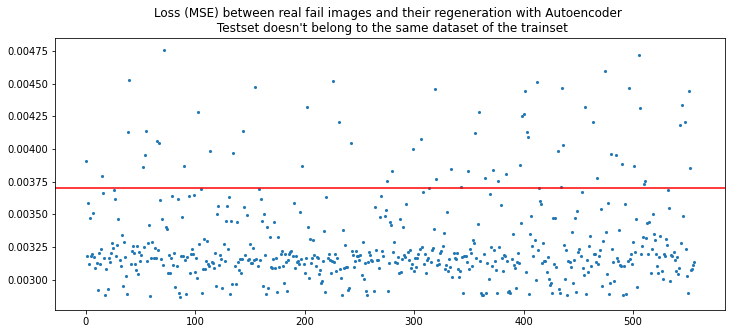

In [ ]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 1, 1)

x = range(len(metrics))
y = metrics[:,0]
ax.set_title("Loss (MSE) between real fail images and their regeneration with Autoencoder \n Testset doesn't belong to the same dataset of the trainset")
ax.scatter(x, y, marker='.',  linewidths=0.1)
ax.axhline(y = 0.0037, color = 'r', linestyle = '-')
plt.show()

In [ ]:
metrics = []
path = glob.glob("./23.3/OK/*.jpg")
for i, file in enumerate(tqdm(path)):
    img = plt.imread(file)
    img = cv2.resize(img,(256,256))
    img  = img / 255.
    img = np.asarray([img])
    metrics.append(model.evaluate(img, img, verbose=0))

100%|██████████| 1260/1260 [01:05<00:00, 19.38it/s]


In [ ]:
metrics = np.asarray(metrics)
np.shape(metrics)
print(metrics[1])
TN = len(metrics[metrics[:, 0] < 0.0037])
print(TN)
print (TN / len(metrics) * 100 )

[0.00329347 0.96302795]
882
70.0


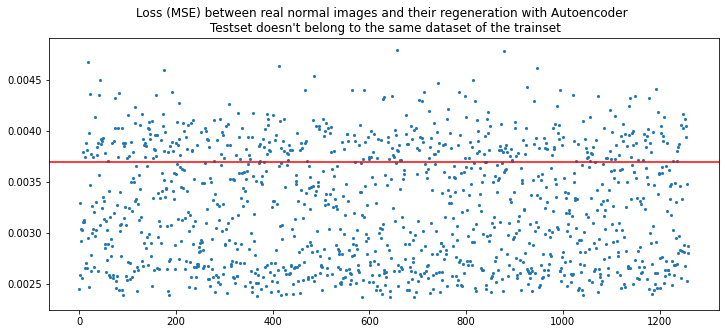

In [ ]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 1, 1)

x = range(len(metrics))
y = metrics[:,0]
ax.set_title("Loss (MSE) between real normal images and their regeneration with Autoencoder \n Testset doesn't belong to the same dataset of the trainset")
ax.scatter(x, y, marker='.',  linewidths=0.1)
ax.axhline(y = 0.0037, color = 'r', linestyle = '-')
plt.show()

In [ ]:
metrics = []
path = glob.glob("./23.3/DEF/*.jpg")
for i, file in enumerate(tqdm(path)):
    img = plt.imread(file)
    img = cv2.resize(img,(256,256))
    img  = img / 255.
    img = np.asarray([img])
    metrics.append(model.evaluate(img, img, verbose=0))

100%|██████████| 1213/1213 [01:02<00:00, 19.44it/s]


In [ ]:
metrics = np.asarray(metrics)
np.shape(metrics)
print(metrics[1])
TN = len(metrics[metrics[:, 0] > 0.0037])
print(TN)
print (TN / len(metrics) * 100 )

[0.00251179 0.98353577]
0
0.0


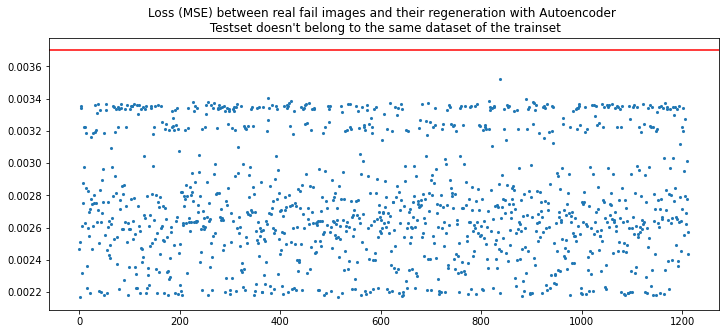

In [ ]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 1, 1)

x = range(len(metrics))
y = metrics[:,0]
ax.set_title("Loss (MSE) between real fail images and their regeneration with Autoencoder \n Testset doesn't belong to the same dataset of the trainset")
ax.scatter(x, y, marker='.',  linewidths=0.1)
ax.axhline(y = 0.0037, color = 'r', linestyle = '-')
plt.show()

1/1 [==============================] - 0s 21ms/step - loss: 0.0025 - accuracy: 0.9846


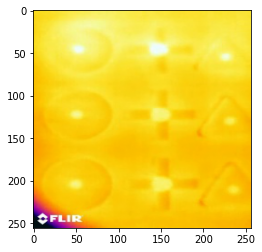

In [ ]:
img = plt.imread("./23.3/DEF/MyRecord2022-03-23T122437136.avi84781.jpg")
img = cv2.resize(img,(256,256))
img  = img / 255.
img = np.asarray([img])
m = model.evaluate(img, img)
img_pred = model.predict(img)
plt.imshow(img[0])

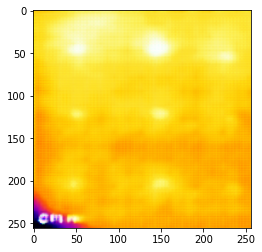

In [ ]:
plt.imshow(img_pred[0])

In [ ]:
from keras.metrics import mean_squared_error as mse

diff_red = abs(img[0,:,:,0] - img_pred[0,:,:,0])
diff_green = abs(img[0,:,:,1] - img_pred[0,:,:,1])
diff_blue = abs(img[0,:,:,2] - img_pred[0,:,:,2])
diff_red = diff_red**2
diff_green = diff_green**2
diff_blue = diff_blue**2

diff_blue = np.mean(diff_blue, axis=0)
diff_green = np.mean(diff_green, axis=0)
diff_red = np.mean(diff_red, axis=0)
diff_red
diff_green
diff_blue

array([0.00684929, 0.00466294, 0.00295503, 0.00266076, 0.00334544,
       0.00331408, 0.00428823, 0.00326971, 0.00262363, 0.00249531,
       0.00432397, 0.00586391, 0.00465873, 0.00380894, 0.00293115,
       0.00330211, 0.00469226, 0.00195576, 0.00151799, 0.0017978 ,
       0.00179365, 0.00224871, 0.00219684, 0.00283103, 0.00367622,
       0.0032486 , 0.00314623, 0.00423789, 0.00580275, 0.00655587,
       0.00342995, 0.00320148, 0.00439132, 0.00564367, 0.00791424,
       0.00534901, 0.00676592, 0.00818544, 0.0062639 , 0.00425439,
       0.00778817, 0.01305572, 0.01104793, 0.00777289, 0.01235254,
       0.01138678, 0.00869217, 0.00956219, 0.01123323, 0.01103493,
       0.01032306, 0.01186857, 0.01655674, 0.0198764 , 0.01894032,
       0.0138719 , 0.01045001, 0.00925091, 0.00663982, 0.00471339,
       0.00607659, 0.00717916, 0.00495666, 0.00309971, 0.00453635,
       0.00537553, 0.00384815, 0.00322051, 0.004849  , 0.00592781,
       0.00435319, 0.00327986, 0.00528936, 0.00674378, 0.00493